## **the Oxford-IIIT Pets dataset**

https://www.robots.ox.ac.uk/~vgg/data/pets/

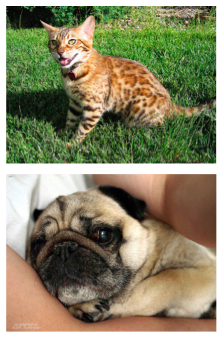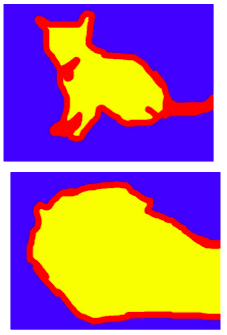    



 Label  | Class name
--------|------------
1       | pet 
2       | background
3       | outline  


In [2]:
# download dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2022-11-23 15:53:27--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-11-23 15:53:27--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 500 Internal Server Error
2022-11-23 15:53:27 ERROR 500: Internal Server Error.

--2022-11-23 15:53:27--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http

In [ ]:
# unzip 
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

The input pictures are stored as JPG files in the images/ folder, and the corresponding segmentation mask is stored as a PNG file with the same name in the annotations/trimaps/ folder.

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")])

target_img_paths = sorted([os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")])


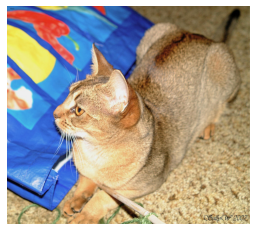

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

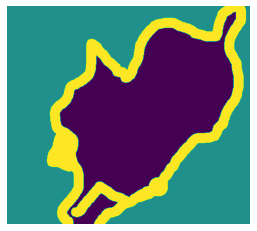

In [ ]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_img_paths[9], color_mode="grayscale"))
display_target(img)

In [ ]:
len(input_img_paths)

7390

In [ ]:
import numpy as np
import random

img_size = (128, 128)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

def path_to_input_image(path): 

  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):

  img = img_to_array(
  load_img(path, target_size=img_size, color_mode="grayscale"))
  img = img.astype("uint8") - 1   # Subtract 1 so that our labels become 0, 1, and 2
  return img

In [ ]:
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")   #(7390, 128, 128, 3)
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")        #(7390, 128, 128, 1)

for i in range(num_imgs):
  
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_img_paths[i])

In [ ]:
input_imgs.shape

(7390, 128, 128, 3)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_imgs, targets, test_size=0.1, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(6651, 128, 128, 3)
(739, 128, 128, 3)


In [ ]:
print(y_train.shape)
print(y_test.shape)

(6651, 128, 128, 1)
(739, 128, 128, 1)


A U-Net consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

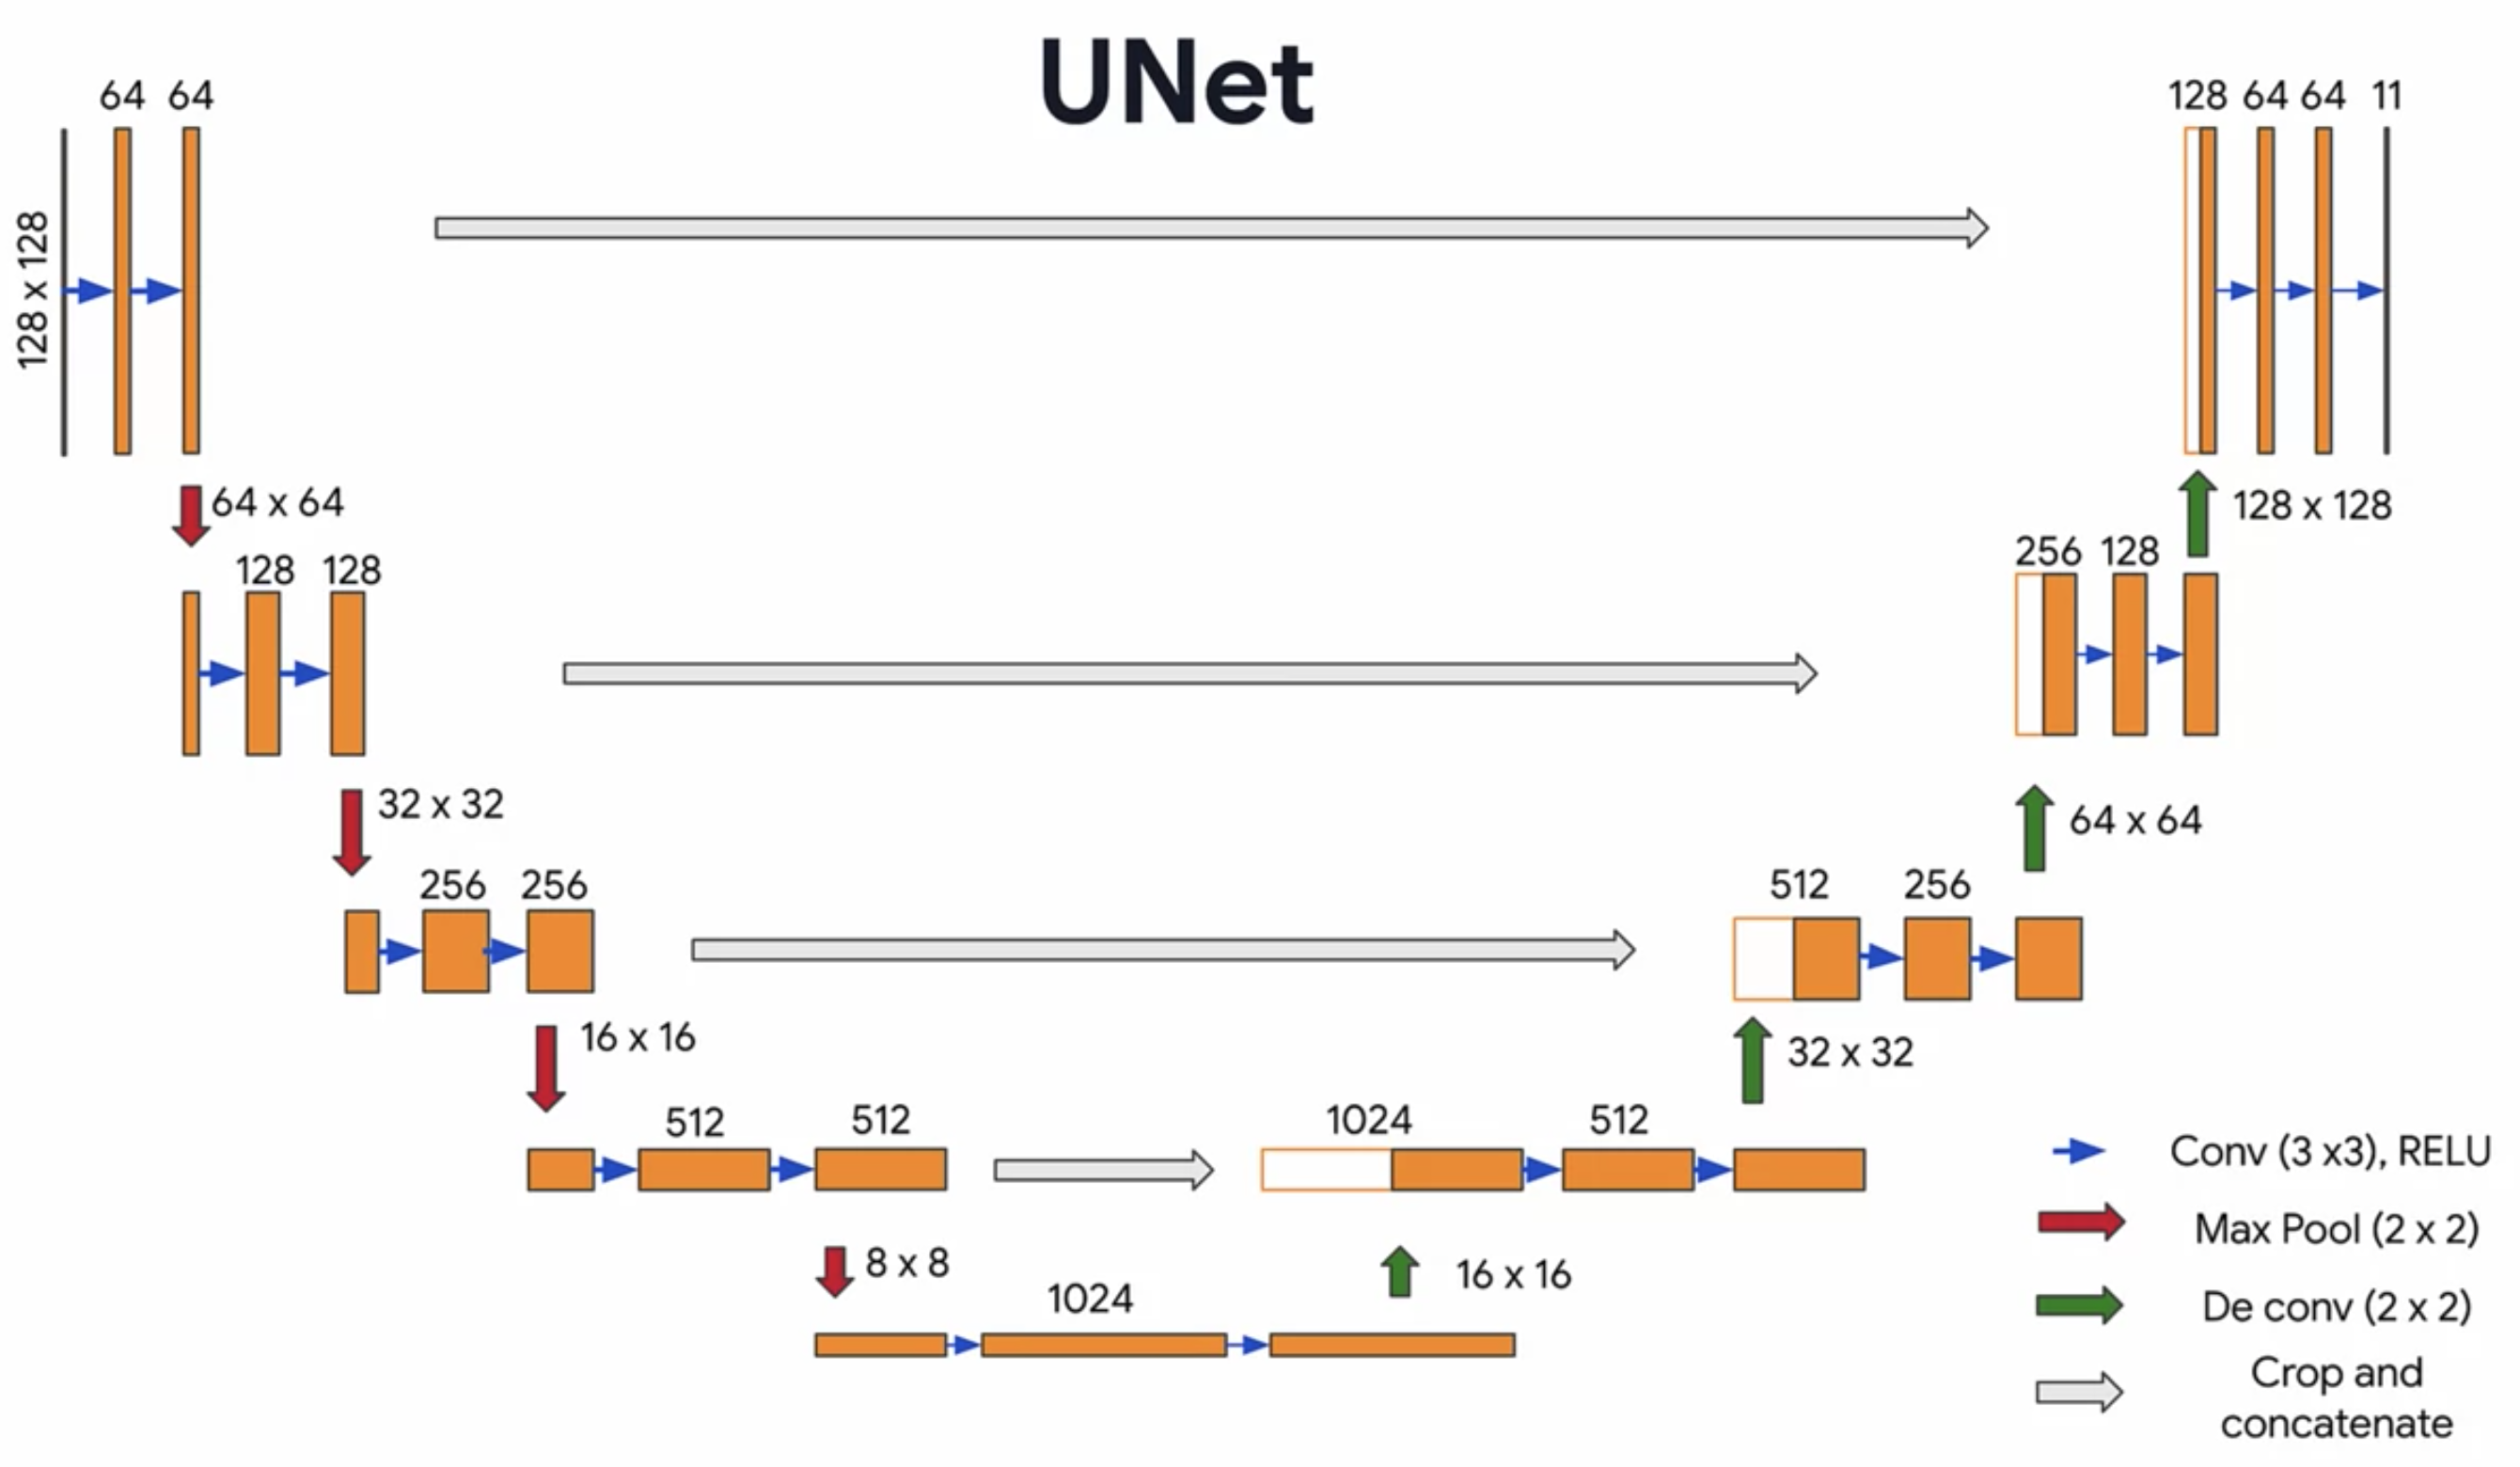

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
 
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                               kernel_initializer="he_normal", padding="same")(x)
    x = tf.keras.layers.Activation("relu")(x)

  return x

In [ ]:
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
 
  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPool2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

In [ ]:
def encoder(inputs):

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2, 2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2, 2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2, 2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2, 2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

In [ ]:
def bottleneck(inputs):

  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

In [ ]:
def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):

  u = tf.keras.layers.Conv2DTranspose(filters=n_filters, kernel_size=kernel_size,
                                      strides=strides, padding="same")(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])                                      
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters=n_filters, kernel_size=3)

  return c

In [ ]:
def decoder(inputs, convs, output_channels):

  f1, f2, f3, f4 = convs
 
  c6 = decoder_block(inputs, conv_output=f4, n_filters=512, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)
  
  c7 = decoder_block(c6, conv_output=f3, n_filters=256, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)
  
  c8 = decoder_block(c7, conv_output=f2, n_filters=128, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)
  
  c9 = decoder_block(c8, conv_output=f1, n_filters=64, kernel_size=(3,3),
                     strides=(2,2), dropout=0.3)
  
  outputs = tf.keras.layers.Conv2D(output_channels, (1,1), activation="softmax")(c9)

  return outputs

In [ ]:
OUTPUT_CHANNELS = 3

def unet():

  inputs = tf.keras.layers.Input(shape=(128, 128, 3,))

  encoder_output, convs = encoder(inputs)

  bottle_neck = bottleneck(encoder_output)

  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

# instantiate the model
unet_model = unet()

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 128, 128, 64  0           ['conv2d[0][0]']                 
                                )                                                             

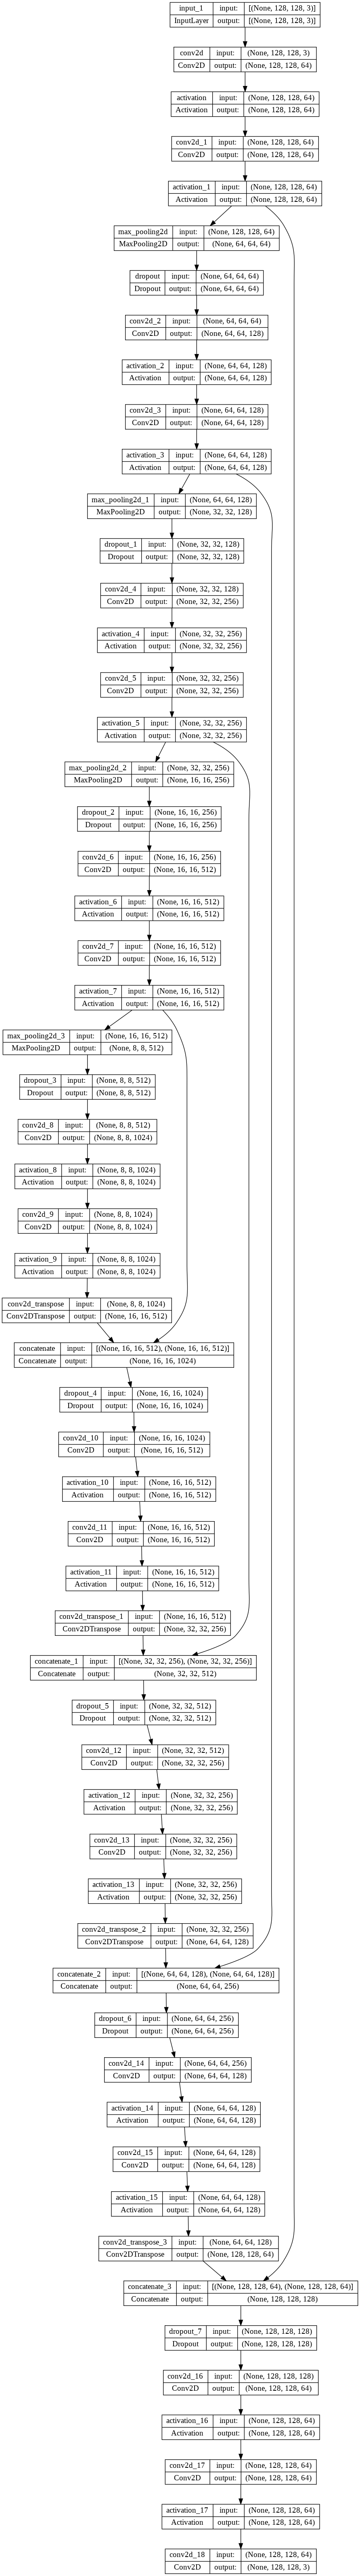

In [ ]:
tf.keras.utils.plot_model(unet_model,show_shapes=True)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(), loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
history = unet_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.15)

Epoch 1/20
89/89 [==============================] - 110s 998ms/step - loss: 11.4686 - accuracy: 0.4832 - val_loss: 0.9319 - val_accuracy: 0.5718
Epoch 2/20
89/89 [==============================] - 81s 915ms/step - loss: 0.8649 - accuracy: 0.5855 - val_loss: 0.8195 - val_accuracy: 0.6015
Epoch 3/20
89/89 [==============================] - 82s 928ms/step - loss: 0.7934 - accuracy: 0.6344 - val_loss: 0.7825 - val_accuracy: 0.6783
Epoch 4/20
89/89 [==============================] - 83s 934ms/step - loss: 0.7369 - accuracy: 0.7006 - val_loss: 0.6933 - val_accuracy: 0.7279
Epoch 5/20
89/89 [==============================] - 83s 935ms/step - loss: 0.6886 - accuracy: 0.7292 - val_loss: 0.6315 - val_accuracy: 0.7540
Epoch 6/20
89/89 [==============================] - 83s 936ms/step - loss: 0.6389 - accuracy: 0.7482 - val_loss: 0.6478 - val_accuracy: 0.7385
Epoch 7/20
89/89 [==============================] - 84s 939ms/step - loss: 0.5926 - accuracy: 0.7664 - val_loss: 0.5906 - val_accuracy: 0.76

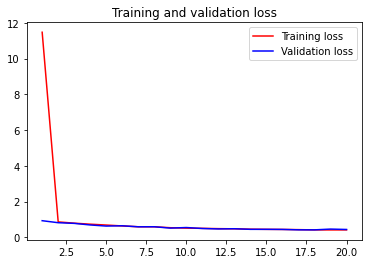

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

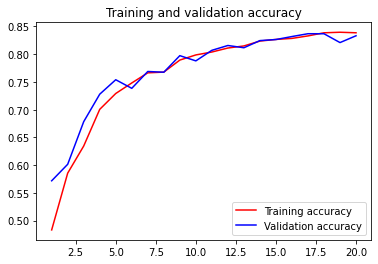

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "r", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

1/1 [==============================] - 0s 17ms/step


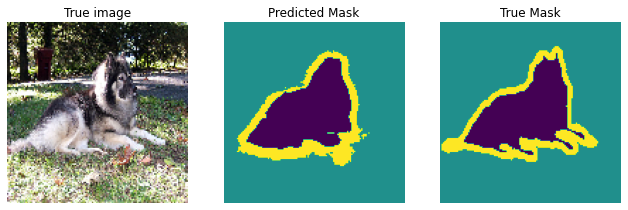

In [ ]:
from tensorflow.keras.utils import array_to_img

fig = plt.figure(figsize=(11,10))
plt.subplot(1,3,1)
i = 4
test_image = X_test[i]
plt.axis("off")
plt.title('True image')
plt.imshow(array_to_img(test_image))

pred = unet_model.predict(np.expand_dims(test_image, 0))[0]

mask = np.argmax(pred, axis=-1)
mask *= 127

plt.subplot(1,3,2)
plt.axis("off")
plt.title('Predicted Mask')
plt.imshow(mask)

plt.subplot(1,3,3)
plt.axis("off")
plt.title('True Mask')
plt.imshow(array_to_img(y_test[i]))